# Machine Vision

In this notebook, we explore architectures for machine vision, i.e., when the inputs are images. While we will work with image classification, several tasks fall within the remits of machine vision. Examples include object segmentation and automatic text recognition.

The references for this part are:
* [Computer Vision for the Humanities: An Introduction to Deep Learning for Image Classification](https://programminghistorian.org/en/lessons/computer-vision-deep-learning-pt1) from the Programming Historian series.
* [Tutorial 5: Inception, ResNet, DenseNet](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) from the UvA DL course.

Let us remember the usual pipeline for Machine Learning tasks, as follows:

<img src="figures/en-or-computer-vision-deep-learning-pt1-06.png" width="900px" heigth="500px">

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os, random
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set_theme('notebook', style='whitegrid')

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
torch.manual_seed(42) # Setting the seed

print("Using torch", torch.__version__)

Using torch 2.5.1+cpu


## Getting the data

The dataset from the Programming Historian lesson is [available here](https://github.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/tree/main), please download it locally to run the following code.

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Create a mapping from string labels to integer labels
        self.label_to_index = {label: idx for idx, label in enumerate(self.annotations['label'].unique())}
        # Create a reverse mapping for integer labels back to string labels
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        label_str = self.annotations.iloc[index, 1]
        # Convert string label to integer
        label = self.label_to_index[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label

# Paths to the data
csv_file = 'ads_upsampled_no_index.csv'  # Path to your CSV file
img_dir = 'images'       # Directory with all the images

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 without preserving aspect ratio, i.e., squishing the image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # This is the mean and std deviation of the ImageNet dataset, in view of using a pre-trained ResNet model
])

# Create the dataset
dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

# Define the train-validation split
train_size = int(0.8 * len(dataset))  # 80% of the data for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for train and validation datasets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterate through the training data
for images, labels in train_loader:
    print(f"Train - images shape: {images.shape}, labels shape: {labels.shape}")
    break

# Example: Iterate through the validation data
for images, labels in val_loader:
    print(f"Validation - images shape: {images.shape}, labels shape: {labels.shape}")
    break

Train - images shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32])
Validation - images shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32])


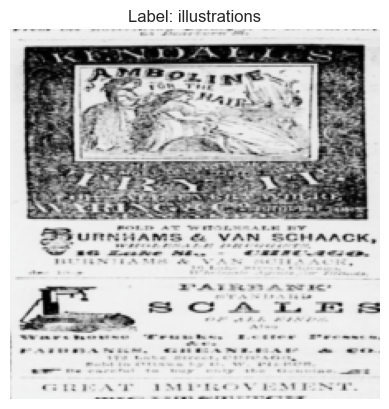

In [7]:
# Example: Plot one image with its label
def plot_example_image(dataset, index):
    image, label = dataset[index]
    
    # Unnormalize the image (this should be done before converting to NumPy)
    image = image * torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2) + torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2)
    
    # Convert the image tensor to a NumPy array for plotting
    image = image.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
    image = image.clip(0, 1)  # Clip values to ensure they are between 0 and 1

    # Get the label string from the index
    label_str = dataset.index_to_label[label]

    # Plotting the image with its label
    plt.imshow(image)
    plt.title(f"Label: {label_str}")
    plt.axis('off')  # Turn off the axis
    plt.show()

# Plot an example image from the dataset (e.g., the first image)
plot_example_image(dataset, index=379)

We will use below a well-established architecture for machine vision tasks, called **ResNet18**. This is the smallest ResNet available. [The ResNet architecture was introduced in Kaiming He et al. in 2015](https://arxiv.org/abs/1512.03385).

Before discussing ResNet, we need to explain **Convolutional Neural Networks (CNNs)**, the building block.

## Understanding Convolutional Neural Networks (CNNs)

**Convolutional Neural Networks (CNNs)** are a class of deep learning models specifically designed to process and analyze data that has a grid-like topology, such as images. CNNs are a type of artificial neural network and are particularly well-suited for tasks like image recognition, object detection, and various other computer vision tasks.

#### Key Components of CNNs:

1. **Convolutional Layers**:
   - The core building block of a CNN is the convolutional layer, which applies a set of filters (also known as kernels) across the input image. These filters move across the image spatially (in two dimensions), performing element-wise multiplications and summing up the results. This operation is called a convolution.
   - The filters help detect features such as edges, textures, and patterns in the image. As you move deeper into the network, the filters become more complex, detecting higher-level features like shapes and objects.

<img src="figures/Convolutional_neural_network.png" width="600px" heigth="600px">

*[From Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)*.

2. **Pooling Layers**:
   - Pooling layers are used to reduce the spatial dimensions of the feature maps, making the computation more efficient and helping to achieve some level of spatial invariance. The most common pooling operation is max pooling, which selects the maximum value in each patch of the feature map.
   - Pooling helps in reducing the number of parameters and computations in the network, which can help prevent overfitting.

<img src="figures/Max_pooling.png" width="600px" heigth="600px">

*[From Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)*.

3. **Fully Connected Layers**:
   - After a series of convolutional and pooling layers, the output is typically passed through one or more fully connected layers (similar to a traditional neural network). These layers combine the features extracted by the convolutional layers to classify the input image or perform other tasks like regression.

4. **Activation Functions**:
   - CNNs use activation functions like ReLU (Rectified Linear Unit) to introduce non-linearity into the model. This non-linearity helps the network learn more complex patterns.

5. **Dropout Layers**:
   - To prevent overfitting, dropout layers are often included, which randomly deactivate a portion of the neurons during training. This encourages the network to learn more robust features.

#### How CNNs Work:
When an image is passed through a CNN, each layer applies a series of transformations to the image, gradually abstracting and recognizing more complex features. For example, the first layers might detect simple edges, while deeper layers might detect parts of objects like eyes, and the final layers might recognize full objects like faces.

#### Advantages of CNNs:
- **Spatial Hierarchy**: CNNs leverage the hierarchical structure of images, where lower layers capture basic features and higher layers capture more complex patterns.
- **Parameter Efficiency**: By sharing the weights of filters across the image, CNNs require fewer parameters than fully connected networks, making them more efficient and less prone to overfitting.

 [A visual CNN explained can be found here](https://poloclub.github.io/cnn-explainer/).

## ResNet Architectures

**ResNet** (Residual Network) is a family of deep convolutional neural networks introduced by [Kaiming He et al. in 2015](https://arxiv.org/abs/1512.03385). The architecture is designed to tackle the challenge of training very deep networks, which typically suffer from problems like vanishing gradients and degradation. ResNet overcomes these issues using residual learning, where shortcut connections bypass one or more layers. 

Here is an illustration of the ResNet (right side), compared with previous architectures:

<img src="figures/res_net.png">

#### ResNet-18
- **Depth**: 18 layers.
- **Architecture**: ResNet-18 uses basic residual blocks, each containing two 3x3 convolutional layers followed by a ReLU activation function. The residual connections bypass these two layers and add the input directly to the output. This network is relatively shallow and is computationally efficient, making it suitable for smaller tasks and scenarios where resources are constrained.
- **Use Case**: Suitable for tasks requiring moderate complexity, often used in academic settings for benchmarks and on datasets that do not require deep architectures.

#### ResNet-50
- **Depth**: Depth: 50 layers
- **Architecture**: ResNet-50 introduces a more complex block called the bottleneck block. A bottleneck block consists of three layers: a 1x1 convolutional layer for reducing dimensionality, a 3x3 convolutional layer, and another 1x1 convolutional layer to restore the dimensionality. This block reduces the number of parameters while maintaining the network’s depth.
- **Use Case**: Often used in practical applications where a balance between model complexity and performance is needed. ResNet-50 is more computationally intensive than ResNet-18 and ResNet-34 but provides better performance on complex tasks.

There are several other ResNet architectures available, also via PyTorch.

## Model, training, and evaluation

In [11]:
# Load pre-trained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1) resulted in:
# RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
# models.regnet_y_400mf(weights=models.RegNet_Y_400MF_Weights.IMAGENET1K_V1) best result 7th epoch: 86.09% Val Accuracy
# models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2) best result 2nd epoch: 86.09% Val Accuracy

# Freeze the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer to match the number of classes
num_features = model.fc.in_features
num_classes = len(dataset.label_to_index)
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU if available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Train Loss: 0.6017, Train Accuracy: 67.05%, Val Loss: 0.5070, Val Accuracy: 81.46%
Epoch [2/5], Train Loss: 0.4366, Train Accuracy: 80.03%, Val Loss: 0.4303, Val Accuracy: 82.78%
Epoch [3/5], Train Loss: 0.3719, Train Accuracy: 86.02%, Val Loss: 0.4039, Val Accuracy: 83.44%
Epoch [4/5], Train Loss: 0.3491, Train Accuracy: 88.35%, Val Loss: 0.3611, Val Accuracy: 85.43%
Epoch [5/5], Train Loss: 0.3542, Train Accuracy: 84.69%, Val Loss: 0.3459, Val Accuracy: 85.43%


### Assessing model predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2391288].


True Label: illustrations
Predicted Label: illustrations
Model Confidence: 0.8929


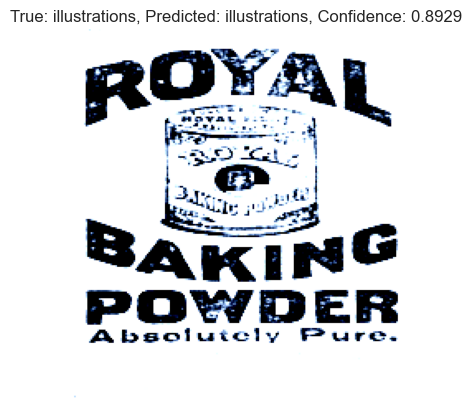

In [12]:
# Get a single batch from the validation loader
model.eval()  # Set the model to evaluation mode
data_iter = iter(val_loader)
images, true_labels = next(data_iter)

# Move data to the device
images = images.to(device)
true_labels = true_labels.to(device)

# Perform a forward pass to get predictions
with torch.no_grad():
    outputs = model(images)
    probabilities = F.softmax(outputs, dim=1)

# Get the predicted label and confidence
_, predicted_labels = torch.max(outputs, 1)
confidence, _ = torch.max(probabilities, 1)

# Randomly select an index for the image to display
index = random.randint(0, images.size(0) - 1)
image = images[index].cpu().permute(1, 2, 0).numpy()  # Convert to HxWxC format for plotting
true_label = true_labels[index].item()
predicted_label = predicted_labels[index].item()
confidence_score = confidence[index].item()

# Convert the label indexes back to string labels using the dataset's index_to_label dictionary
true_label_str = val_dataset.dataset.index_to_label[true_label]
predicted_label_str = val_dataset.dataset.index_to_label[predicted_label]

# Print the true label, predicted label, and confidence
print(f"True Label: {true_label_str}")
print(f"Predicted Label: {predicted_label_str}")
print(f"Model Confidence: {confidence_score:.4f}")

# Optionally, display the image
plt.imshow(image)
plt.title(f"True: {true_label_str}, Predicted: {predicted_label_str}, Confidence: {confidence_score:.4f}")
plt.axis('off')
plt.show()

---

### Exercise 1 (Easy)

Modify the code to use different pre-trained architectures. [See here for ideas.](https://pytorch.org/vision/stable/models.html)

### Exercise 2 (Medium)

Implement a simple convolutional neural network to perform binary image classification. [Check this tutorial for inspiration.](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [3]:
from torchvision.datasets import CIFAR10

transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

train_data = CIFAR10(root="data", train=True, download=True, transform=transf)
test_data = CIFAR10(root="data", train=False, download=True, transform=transf)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def to_binary(dataset):
    dataset.targets = [0 if label <= 7 else 1 for label in dataset.targets]
    

to_binary(train_data)
to_binary(test_data)


In [7]:
class deadOrAlive(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 6, 2) 
        self.c2 = nn.Conv2d(6, 16, 2)
        self.c3 = nn.Conv2d(16, 38, 2)
        self.fc1 = nn.Linear(342, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)),2)
        x = F.max_pool2d(F.relu(self.c2(x)),2)
        x = F.max_pool2d(F.relu(self.c3(x)),2)
        x = x.view(-1, self.flatfeats(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x    

    def flatfeats(self, x):
        size = x.size()[1:]
        feats = 1
        for dim in size:
            feats *= dim
        return feats
    
doa = deadOrAlive()
    

In [11]:
def trainDoA(model, epochs, training):
    model.train()
    running_loss = 0
    lf = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr = 0.01)
    for e in range(epochs):
        for i, data in enumerate(training, 0):
            img, label = data

            opt.zero_grad()
            preds = model(img)
            loss = lf(preds, label)
            running_loss += loss.item()
            loss.backward()
            opt.step()

            if i%2000 == 1999:
                print(f"[{e+1}/{i+1}] loss: {running_loss/2000}")
                running_loss = 0



In [12]:
loader = DataLoader(train_data, batch_size=4, shuffle=True)

trainDoA(doa, 3, loader)

[1/2000] loss: 0.34907365861418654
[1/4000] loss: 0.3420478299600072
[1/6000] loss: 0.33980176991247574
[1/8000] loss: 0.3307516982514644
[1/10000] loss: 0.31848283295275176
[1/12000] loss: 0.31912405852621306
[2/2000] loss: 0.3997750266410876
[2/4000] loss: 0.30270175324532467
[2/6000] loss: 0.31001216421686695
[2/8000] loss: 0.3026546901005786
[2/10000] loss: 0.29963321213200106
[2/12000] loss: 0.29383669605481555
[3/2000] loss: 0.3544578392140538
[3/4000] loss: 0.2812928782610106
[3/6000] loss: 0.29292229339366893
[3/8000] loss: 0.2746128712803293
[3/10000] loss: 0.2809245992039614
[3/12000] loss: 0.26765702939851327


In [14]:
testload = DataLoader(test_data, batch_size=4, shuffle=True)

doa.eval()
correct=0
total=0

with torch.no_grad():
    for data in testload:
        images,labels = data
        preds = doa(images)
        _, predictions = torch.max(preds.data, 1)
        correct += (predictions == labels).sum().item()
        total += predictions.size(0)

        accuracy = correct/total

print ("accuracy:", accuracy*100)


        



accuracy: 87.88


### Exercise 3 (Hard)

Look at the [WikiArt dataset](https://github.com/cs-chan/ArtGAN/blob/master/WikiArt%20Dataset/README.md). Pick a task of your choice among artist, genre, and style classification. Design, implement, and evaluate a model for this task. Consider starting by reusing the simple model we devised above, and expand from it using more advanced architectures. You can use pre-trained models or implement your own approach from scratch, or both.

---